In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import random
import numpy as np
import math
import sys

In [188]:
# Create instance of grid.
class Agent:
    def __init__(self, colorId, color, x, y):
        self.color = color
        self.colorId = colorId
        self.x = x
        self.y = y
        
    def __str__(self):
        return str(self.colorId)
    
    def getX(self):
        return self.x
    def getY(self): 
        return self.y
    def getCoord(self):
        return (self.x, self.y)
    def getColorId(self):
        return self.colorId
    def getColor(self):
        return self.color
    
    def setX(self, newX):
        self.x = newX
    def setY(self, newY):
        self.y = newY
    def setCoord(self, newX, newY):
        self.x = newX
        self.y = newY

In [190]:
class District:
    def __init__(self, length, width, numOfColor, colorList):
        self.length = length # x
        self.width = width # y
        self.tiles = [[0 for j in range(self.width)] for i in range(self.length)]
        self.count = 0
        self.summary = dict()
        self.numOfColor = numOfColor
        self.colorList = colorList
        
    def addMember(self, x, y, colorId, check = True):
        if not check or newMemberIsPhysicallyContinuous(self, x, y):
            self.tiles[x][y] = colorId
            self.count +=1 
            if colorId not in self.summary:
                self.summary[colorId] = 1
            else: 
                self.summary[colorId] += 1
            return True
        else:
            return False
        
    def newMemberIsPhysicallyContinous(self, x, y):
        if not (x >= 0 and x < self.length) or not (y >= 0 and y < self.width): 
            return False
        if (x + 1 < self.length and self.tiles[x + 1][y] >= 1):
            return True
        if (x - 1 >= 0 and self.tiles[x-1][y] >= 1):
            return True
        if (y + 1 < self.width and self.tiles[x][y+1] >= 1):
            return True
        if (y-1 >= 0 and self.tiles[x][y-1] >= 1):
            return True
        return False
        
    def isPhysicallyContinuous(self):
        visited = [[False for j in range(self.width)]for i in range(self.length)]
        AlreadyReachedOneIsland = False
        for x in range(self.length):
            for y in range(self.width):
                # once we reached one island, we trigger DFS. All cells inside the island should be marked as visited. 
                # After that, if we reach another cell > 0 and not visited it yet, it means we reached another island, we return False. 
                if self.tiles[x][y] > 0 and not visited[x][y]:
                    if AlreadyReachedOneIsland:
                        return False
                    else:
                        AlreadyReachedOneIsland = True
                        self.DFS(x, y, visited)
        return True
    
    def DFS(self, x, y, visited):
        rowNbr = [-1, 0, 0, 1]
        colNbr = [0, -1, 1, 0]
        
        visited[x][y] = True
        
        for k in range(4):
            if self.isSafe(x + rowNbr[k], y + colNbr[k]) \
                and not visited[x + rowNbr[k]][y + colNbr[k]] \
                and self.tiles[x + rowNbr[k]][y + colNbr[k]] > 0:
                self.DFS(x + rowNbr[k], y + colNbr[k], visited)
    
    def isSafe(self, x, y):
        if x >= 0 and x < self.length and y >= 0 and y < self.width:
            return True
        return False
                    

    def ejectMember(self, x, y):
        if (x < 0 or x > self.length or y < 0 or y > self.width):
            return None
        
        if self.tiles[x][y] == 0:
            return None
        else: 
            temp = self.tiles[x][y]
            self.tiles[x][y] = 0
            if self.isPhysicallyContinuous():
                return temp
            else:
                self.tiles[x][y] = temp
                return None
    
    def show(self):
        actualColorList = []
        # +1 because the summary will always contain only non-white color, but the white color is still important. 
        for i in range(len(self.summary) + 1):
            actualColorList.append(self.colorList[i])
        bufferList = [] 
        for i in range(self.width):
            bufferList.append(i % len(self.colorList))
        plt.imshow([bufferList] + self.tiles, cmap=matplotlib.colors.ListedColormap(self.colorList))
        plt.show()
        
    def getIm(self):
        actualColorList = []
        for i in range(len(self.summary) + 1):
            actualColorList.append(self.colorList[i])
        return self.tiles, matplotlib.colors.ListedColormap(actualColorList)
    
    def getSummary(self, percentage = False):
        if not percentage:
            return self.summary
        else:
            tempDict = self.summary
            sumCount = sum(tempDict.values())
            for i in tempDict:
                tempDict[i] /= sumCount
            return tempDict
    
    def balanceTwoDistrictsIfAdjacent(self, district2, method = "compact"):
        # method 1: sequantial merge. 
        if method == 'extreme':
            for i in range(self.length):
                for j in range(self.width):
                    # if population of two districts are even
                    if self.getCount() <=  district2.getCount():
                        return
                    if random.uniform(0, 1) < 0.2 and self.tiles[i][j] != 0 and district2.newMemberIsPhysicallyContinous(i, j):
                        tempColorId = self.tiles[i][j]
                        self.tiles[i][j] = 0
                        if (self.isPhysicallyContinuous()):
                            self.count -= 1 
                            self.summary[tempColorId] -= 1
                            district2.addMember(i, j, tempColorId, False)
                        else:
                            self.tiles[i][j] = tempColorId
    
        # method 2: adjacent cell merge first. 
        # each time, pick out all the tiles that are adjacent to the other district.
        if method == 'compact':
            itr = 0
            while(self.getCount() > district2.getCount()):
                itr += 1

                adjacentTiles = set()

                for i in range(self.length):
                    for j in range(self.width):
                        # pick out all the cells here that is adjacent that is the other district. 
                        if self.tiles[i][j] != 0 and district2.newMemberIsPhysicallyContinous(i, j):
                            adjacentTiles.add((i, j))

                # if no tiles are adjacent, we break out of the loop. 
                if (len(adjacentTiles) == 0):
                    break

                succeededCount = 0
                while(self.getCount() > district2.getCount() and len(adjacentTiles) > 0):
                    # we add this tile if after removing it we are still physically continuous. 
                    x, y = adjacentTiles.pop()        
                    tempColorId = self.tiles[x][y]
                    self.tiles[x][y] = 0
                    if (self.isPhysicallyContinuous()):
                        self.count -= 1
                        self.summary[tempColorId] -= 1
                        district2.addMember(x, y, tempColorId, check=False)
                        succeededCount += 1
                    else:
                        self.tiles[x][y] = tempColorId
                # if none of the adjacent tiles can be given out, break
                if succeededCount == 0:
                    break

    def jointDisplay(self, district):
        jointTiles = [[0 for j in range(self.width)] for i in range(self.length)]
        for i in range(self.length):
            for j in range(self.width):
                if self.tiles[i][j] != 0:
                    jointTiles[i][j] = 1
                if district.tiles[i][j] != 0:
                    jointTiles[i][j] = 2
                actualColorList = []
        plt.imshow(jointTiles, cmap=matplotlib.colors.ListedColormap(self.colorList))
        plt.show()
        
    def getCount(self):
        return self.count
    
    def tileIsOnEdge(self, x, y):
        if not (x >= 0 and x < self.length) or not (y >= 0 and y < self.width): 
            return False
        # right
        count = 0
        if (x + 1 < self.length and self.tiles[x + 1][y] >= 1):
            count += 1
        # left
        if (x - 1 >= 0 and self.tiles[x-1][y] >= 1):
            count += 1
        # down
        if (y + 1 < self.width and self.tiles[x][y+1] >= 1):
            count += 1
        # up
        if (y-1 >= 0 and self.tiles[x][y-1] >= 1):
            count += 1
        if count == 4:
            return False
        return True
    
    def getMajorityColorId(self):
        max_value = max(self.summary.values())
        max_key = max(self.summary, key=self.summary.get)
        return max_key
    
    def __str__(self):
        return str([[self.tiles[i][j] for j in range(self.width)] for i in range(self.length)])

In [208]:
class Grid:
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.population = length * width
        self.grid = []
        self.dict = {}
        self.districts = None
        self.colorMap = None
        self.colors = None
        self.method = None
        
    def initializeMap(self, method = 'uniform', num = 7, grid = None):
        # initialized Agent should never has colorId = 0, since 0 is for white space filler. 
        self.method = method
        
        if num > 7 or num < 1: 
            raise ValueError("Argument num has to be an integer between 1 to 7. ")
            
        if method == "naive":
            self.colors = ['tomato']
            self.colorMap = matplotlib.colors.ListedColormap(self.colors)
            self.grid = [[Agent(1, 'tomato', i, j) for j in range(self.width)] for i in range(self.length)]
            
        if method == "uniform":
            # initialize color assignment 
            colorResort = ['red', 'blue', 'yellow', 'lightgreen', 'pink', 'brown', 'gold']
            tempColors = []
            for i in range(0, num):
                tempColors.append(colorResort[i])
            self.colors = tempColors
            self.colorMap = matplotlib.colors.ListedColormap(self.colors)
            
            # initialize summary
            for i in range(num):
                self.dict[self.colors[i]] = 0
            
            self.grid = []
            for i in range(self.length):
                templ = []
                for j in range(self.width):
                    value = random.uniform(0, 1)
                    cap = 1/num
                    count = 0
                    while (cap <= 1):
                        if value <= cap:
                            templ.append(Agent(count + 1, self.colors[count], i, j))
                            self.dict[self.colors[count]] += 1
                            break
                        else:
                            cap += 1/num
                            count += 1
                self.grid.append(templ)
                
        # Nebraska, enum is set to 2, with one huge concentration of a particular enum. 
        if method == 'Nebraska':
            self.colors = ['tomato', 'royalblue']
            self.colorMap = matplotlib.colors.ListedColormap(self.colors)
            
            cityCenter_x = random.randint(0, self.length)
            cityCenter_y = random.randint(0, self.width)
            self.grid = []
            self.dict['tomato'] = 0
            self.dict['royalblue'] = 0
            for i in range(self.length):
                templ = []
                for j in range(self.width):
                    # the distance between this agent and the city center. 
                    distance = math.sqrt((abs(i - cityCenter_x) ** 2) + (abs(j - cityCenter_y) ** 2))
                    prob = random.uniform(0, 1)
                    lratio = (self.length - distance) / self.length
                    wratio = (self.width - distance) / self.width
                    amplifier = 1.2
                    threshold = lratio * wratio * amplifier

                    if prob < threshold: 
                        templ.append(Agent(colorId = 2, color = self.colors[1], x=i, y=j))
                        self.dict['royalblue'] += 1
                    else:
                        templ.append(Agent(colorId = 1, color = self.colors[0], x=i, y=j))
                        self.dict['tomato'] += 1
                self.grid.append(templ)
            
        # Paris, five parties. Red being far left, purple being far right, palegreen being in the middle. 
        # closer to the city means more likely being toward the left. 
        # further away from the city means more likely to the right. 
        if method == "Warsaw":
            num = 5
            self.colors = ["tomato", "orange", "palegreen", "royalblue", "mediumorchid"]
            self.colorMap = matplotlib.colors.ListedColormap(self.colors)
            
            for color in self.colors:
                self.dict[color] = 0
            
            cityCenter_x = random.randint(self.length * 0.3, self.length * 0.7)
            cityCenter_y = random.randint(self.width * 0.3, self.width * 0.7)

            for i in range(self.length):
                templ = []
                for j in range(self.width):
                    # the distance between this agent and the city center. 
                    distance = math.sqrt((abs(i - cityCenter_x) ** 2) + (abs(j - cityCenter_y) ** 2))
                    prob = random.uniform(0, 1)
                    lratio = (self.length - distance) / self.length
                    wratio = (self.width - distance) / self.width
                    amplifier = 1.2
                    threshold = lratio * wratio * amplifier

                    if prob < threshold/2: 
                        templ.append(Agent(colorId = 1, color = self.colors[0], x=i, y=j))
                        self.dict['tomato'] += 1
                    if threshold/2 < prob and prob < 5 * threshold/4:
                        templ.append(Agent(colorId = 2, color = self.colors[1], x=i, y=j))
                        self.dict['orange'] += 1
                    if 5*threshold/4 < prob and prob < 12 * threshold / 4 :
                        templ.append(Agent(colorId = 3, color = self.colors[2], x=i, y=j))
                        self.dict['palegreen'] += 1
                    if 12 * threshold / 4 < prob and prob < 50 * threshold / 4 :
                        templ.append(Agent(colorId = 4, color = self.colors[3], x=i, y=j))
                        self.dict['royalblue'] += 1
                    if 50 * threshold / 4 < prob:
                        templ.append(Agent(colorId = 5, color = self.colors[4], x=i, y=j))
                        self.dict['mediumorchid'] += 1
                        
                self.grid.append(templ)
                        
                    
    def __str__(self):
        return str([[str(self.grid[i][j]) for j in range(self.width)] for i in range(self.length)])

    def displayGrid(self):
        plt.imshow(self.getColorIds(), cmap = self.colorMap)
        plt.show()
    
    def getColorIds(self):
        return [[self.grid[i][j].getColorId() for j in range(self.width)] for i in range(self.length)]
    
    def getSummary(self, percentage = False):
        if not percentage:
            return self.dict
        tempDict = self.dict
        sumCount = sum(tempDict.values())
        for i in tempDict:
            tempDict[i] /= sumCount
        return tempDict

    def drawDistricts(self, numOfDistrict):
        colorList = self.colors
        self.districts = [District(self.length, self.width, len(self.colors), ['white']+colorList) for i in range(numOfDistrict)]
        districtCenters = []
        for i in range(numOfDistrict):
            center_x = random.randint(0, self.length)
            center_y = random.randint(0, self.width)
            districtCenters.append((center_x, center_y))
            
        for i in range(self.length):
            for j in range(self.width):
                minIdx = -1
                minDistance = 999999
                for k in range(len(districtCenters)):
                    (x, y) = districtCenters[k]
                    dist = ((x - i)**2 + (y - j)**2)**0.5
                    if dist < minDistance:
                        minIdx = k
                        minDistance = dist
                self.districts[minIdx].addMember(i, j, self.grid[i][j].getColorId(), check = False)
        
        lastPopulationList = [] 
        while(not self.districtsHasBalancedPopulation()):
            # sort districtsId by their population
            ids = [i for i in range(len(self.districts))]
            populationList = []
            for district in self.districts:
                populationList.append(district.getCount())
            ids = [x for _,x in sorted(zip(populationList,ids))]
            
            if str(populationList) == str(lastPopulationList):
                break
            else:
                lastPopulationList = populationList
                    
            for minPointer in range(0, len(self.districts)):
                for maxPointer in range(0, len(self.districts)):
                    minId = ids[minPointer]
                    maxId = ids[maxPointer]
                    if self.districts[minId].getCount() > self.districts[maxId].getCount():
                        temp = minId
                        minId = maxId
                        maxId = temp
                        
                    self.balanceTwoDistrictsIfAdjacent(minId, maxId)    
        
    def districtsHasBalancedPopulation(self):
        sum = 0
        for district in self.districts:
            sum += district.getCount()
        average = sum / len(self.districts)
        diff = 0
        for district in self.districts:
            diff += abs(district.getCount() - average)
        if diff >= 0.05 * self.population:
            return False
        return True
    
    def balanceTwoDistrictsIfAdjacent(self, minId, maxId):
        self.districts[maxId].balanceTwoDistrictsIfAdjacent(self.districts[minId])
        
    def showDistrict(self, index):
        self.districts[index].show()
        
    def showAllDistricts(self):
        fig, axs = plt.subplots(1, len(self.districts), figsize=(self.length, self.width))
        for i in range(len(self.districts)):
            tiles, colorMapOfDistrict = self.districts[i].getIm()
            axs[i].imshow(tiles, cmap = colorMapOfDistrict)
        plt.show()
        
    def getDistrictSummary(self, index):
        return self.districts[index].getSummary(percentage = True)
    
    def getDistrictCount(self, index):
        return self.districts[index].getCount()
    
    def showDistrictsResult(self, method = "flat", sort=True):
        if method == 'district':
            tempGrid = [[0 for j in range(self.width)] for i in range(self.length) ]
            for district in self.districts:
                majorityId = district.getMajorityColorId()
                districtTiles = district.tiles
                for i in range(district.length):
                    for j in range(district.width):
                        if districtTiles[i][j] > 0:
                            if district.tileIsOnEdge(i, j):
                                tempGrid[i][j] = 0
                            else:
                                tempGrid[i][j] = majorityId
            bufferList = []
            for i in range(self.width):
                bufferList.append(i % len(['white']+self.colors))
            colorMap = matplotlib.colors.ListedColormap(['white'] + self.colors)
            plt.imshow([bufferList] + tempGrid, cmap = colorMap)
            plt.show()
            
        if method == 'flat':
            if sort:
                fig, ax = plt.subplots()
                tempDict = {}
                for i in range(len(self.districts)):
                    majorityColorId = self.getDistrictMajorityColorId(i) - 1
                    majorityColor = self.colors[majorityColorId]
                    if majorityColor not in tempDict.keys():
                        tempDict[majorityColor] = 1
                    else:
                        tempDict[majorityColor] += 1
                position = 0
                for color in tempDict.keys():
                    for i in range(tempDict[color]):
                        ax.add_patch(plt.Circle((position * 10, 0), 3, color=color))
                        position += 1
                ax.set_aspect('equal', adjustable='datalim')
                ax.plot()
                plt.show()
            else: 
                fig, ax = plt.subplots()
                for i in range(len(self.districts)):
                    # the returned majorityId is int >= 1. 0 indicate 0 which is space filler. 
                    majorityColorId = self.getDistrictMajorityColorId(i)
                    # because the majorityId is >= 1, 
                    color = None
                    for j in range(len(self.colors)):
                        if majorityColorId-1 == j:
                            color = self.colors[j]
                            break
                    ax.add_patch(plt.Circle((i * 10, 0), 3, color=color))
                ax.set_aspect('equal', adjustable='datalim')
                ax.plot()
                plt.show()

    def getDistrictMajorityColorId(self, index):
        return self.districts[index].getMajorityColorId()
        
    def districtData(self, index):
        return str(self.districts[index])

    def tileIsOnEdge(self, x, y):
        if not self.isSafe(x, y):
            return False
        
        if not (x >= 0 and x < self.length) or not (y >= 0 and y < self.width): 
            return False
        # right
        count = 0
        if (x + 1 < self.length and self.tiles[x + 1][y] >= 1):
            count += 1
        # left
        if (x - 1 >= 0 and self.tiles[x-1][y] >= 1):
            count += 1
        # down
        if (y + 1 < self.width and self.tiles[x][y+1] >= 1):
            count += 1
        # up
        if (y-1 >= 0 and self.tiles[x][y-1] >= 1):
            count += 1
        if count == 4:
            return False
        if count == 2:
            return False
        return True
    
    def isSafe(x, y):
        if (x >= 0 and x < self.length) or not (y >= 0 and y < self.width): 
            return True
        return False

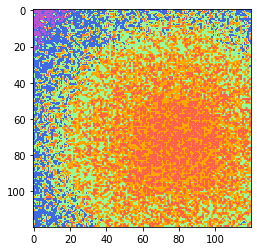

Summary: {'tomato': 0.22722222222222221, 'orange': 0.31930555555555556, 'palegreen': 0.3036111111111111, 'royalblue': 0.1411111111111111, 'mediumorchid': 0.00875}


KeyboardInterrupt: 

In [213]:
#Paris
Warsaw = Grid(120, 120)
Warsaw.initializeMap('Warsaw')
Warsaw.displayGrid()
print("Summary:", Warsaw.getSummary(percentage = True))
numberOfDistrict = 31

Warsaw.drawDistricts(numberOfDistrict)

Warsaw.showDistrictsResult(method = 'district')
Warsaw.showDistrictsResult()

Warsaw.showAllDistricts()

# for i in range(numberOfDistrict):
#     print("\nDistrict #", i + 1)
#     Paris.showDistrict(i)
#     print(Paris.getDistrictSummary(i))
#     print("Population =", Paris.getDistrictCount(i))
#     print("MajorityColor =", Paris.getDistrictMajorityColorId(i))

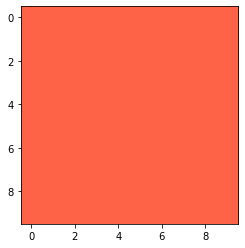

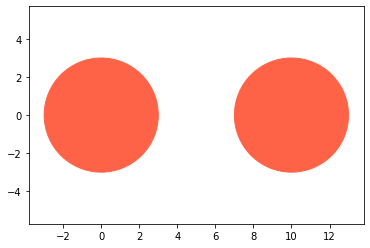

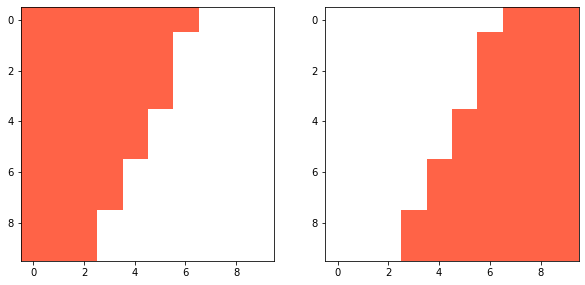


District # 1


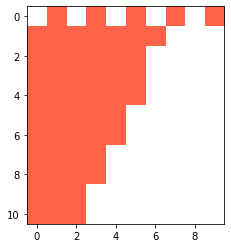

{1: 1.0}
Population = 49
MajorityColor = 1

District # 2


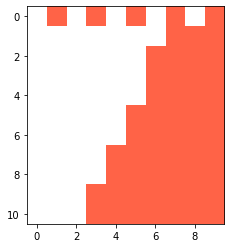

{1: 1.0}
Population = 51
MajorityColor = 1


In [196]:
#uniform
NaiveGrid = Grid(10, 10)
NaiveGrid.initializeMap('naive')
NaiveGrid.displayGrid()
numberOfDistrict = 2

NaiveGrid.drawDistricts(numberOfDistrict)

NaiveGrid.showDistrictsResult()
NaiveGrid.showAllDistricts()

for i in range(numberOfDistrict):
    print("\nDistrict #", i + 1)
    NaiveGrid.showDistrict(i)
    print(NaiveGrid.getDistrictSummary(i))
    print("Population =", NaiveGrid.getDistrictCount(i))
    print("MajorityColor =", NaiveGrid.getDistrictMajorityColorId(i))

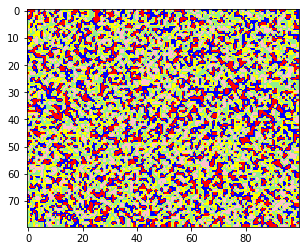

Summary: {'red': 0.20175, 'blue': 0.201625, 'yellow': 0.202, 'lightgreen': 0.194875, 'pink': 0.19975}


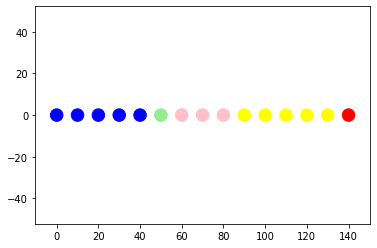

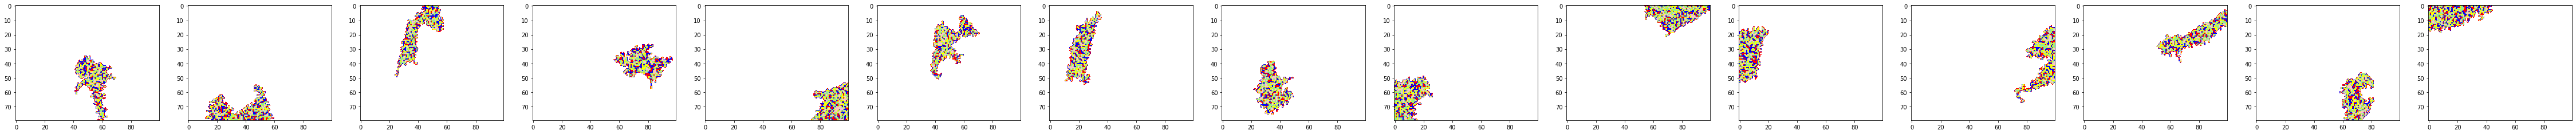


District # 1


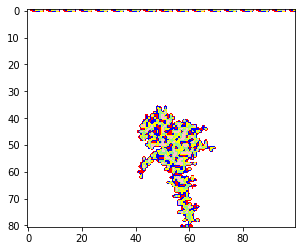

{2: 0.21772639691714837, 3: 0.20616570327552985, 5: 0.19460500963391136, 4: 0.1907514450867052, 1: 0.1907514450867052}
Population = 519
MajorityColor = 2

District # 2


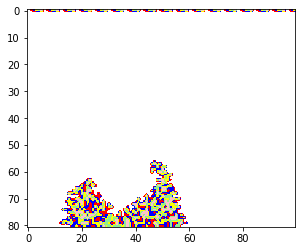

{3: 0.18888888888888888, 4: 0.17407407407407408, 5: 0.2074074074074074, 2: 0.21481481481481482, 1: 0.21481481481481482}
Population = 540
MajorityColor = 2

District # 3


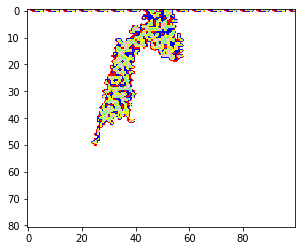

{3: 0.17190388170055454, 4: 0.21811460258780038, 1: 0.19963031423290203, 5: 0.1977818853974122, 2: 0.21256931608133087}
Population = 541
MajorityColor = 4

District # 4


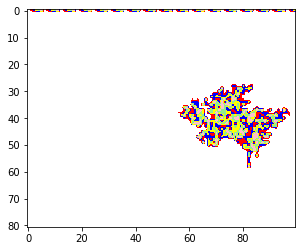

{2: 0.2546816479400749, 1: 0.21348314606741572, 5: 0.1760299625468165, 3: 0.18352059925093633, 4: 0.17228464419475656}
Population = 534
MajorityColor = 2

District # 5


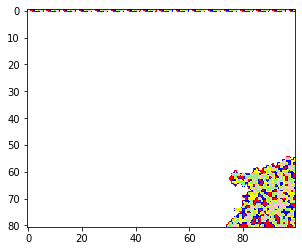

{2: 0.18864097363083165, 3: 0.19066937119675456, 4: 0.20081135902636918, 5: 0.2150101419878296, 1: 0.20486815415821502}
Population = 493
MajorityColor = 5

District # 6


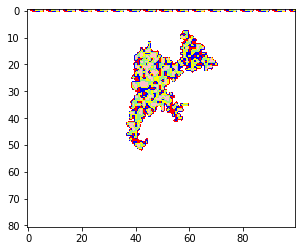

{5: 0.23985239852398524, 2: 0.17158671586715868, 3: 0.1937269372693727, 1: 0.2177121771217712, 4: 0.17712177121771217}
Population = 542
MajorityColor = 5

District # 7


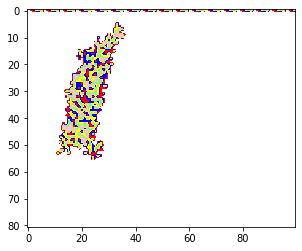

{5: 0.2033271719038817, 1: 0.18114602587800369, 2: 0.2033271719038817, 4: 0.19593345656192238, 3: 0.21626617375231053}
Population = 541
MajorityColor = 3

District # 8


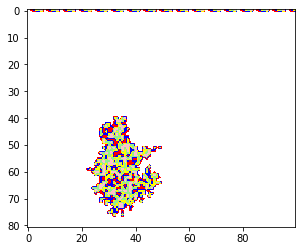

{2: 0.16417910447761194, 4: 0.208955223880597, 1: 0.208955223880597, 3: 0.1958955223880597, 5: 0.22201492537313433}
Population = 536
MajorityColor = 5

District # 9


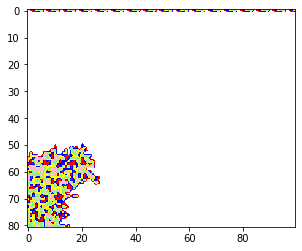

{4: 0.21572212065813529, 1: 0.19195612431444242, 2: 0.1809872029250457, 3: 0.22486288848263253, 5: 0.18647166361974407}
Population = 547
MajorityColor = 3

District # 10


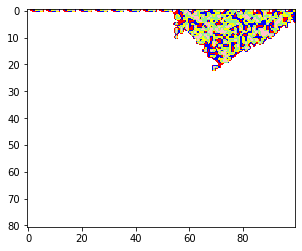

{1: 0.17712177121771217, 5: 0.19557195571955718, 3: 0.1937269372693727, 2: 0.21955719557195572, 4: 0.2140221402214022}
Population = 542
MajorityColor = 2

District # 11


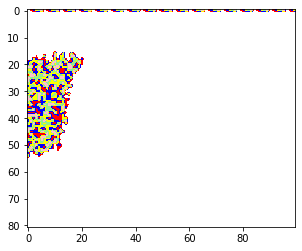

{5: 0.19230769230769232, 2: 0.21794871794871795, 3: 0.2032967032967033, 4: 0.17216117216117216, 1: 0.21428571428571427}
Population = 546
MajorityColor = 2

District # 12


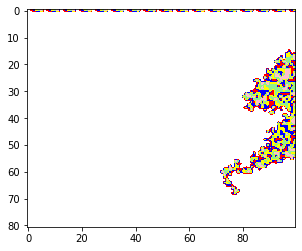

{3: 0.21910112359550563, 2: 0.1853932584269663, 1: 0.20786516853932585, 5: 0.1704119850187266, 4: 0.21722846441947566}
Population = 534
MajorityColor = 3

District # 13


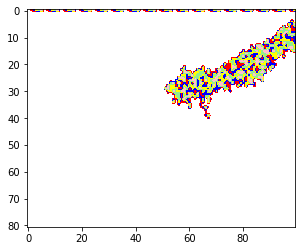

{1: 0.18853974121996303, 3: 0.20517560073937152, 5: 0.2033271719038817, 4: 0.20147874306839186, 2: 0.20147874306839186}
Population = 541
MajorityColor = 3

District # 14


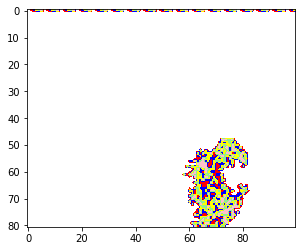

{1: 0.18637274549098196, 2: 0.20040080160320642, 5: 0.2124248496993988, 4: 0.18236472945891782, 3: 0.218436873747495}
Population = 499
MajorityColor = 3

District # 15


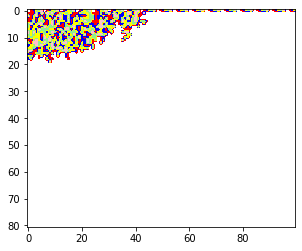

{1: 0.22752293577981653, 5: 0.181651376146789, 2: 0.1908256880733945, 4: 0.181651376146789, 3: 0.21834862385321102}
Population = 545
MajorityColor = 1


In [50]:
#uniform
UniformGrid = Grid(80, 100)
UniformGrid.initializeMap('uniform', 5)

UniformGrid.displayGrid()
print("Summary:", UniformGrid.getSummary(percentage = True))

numberOfDistrict = 15
UniformGrid.drawDistricts(numberOfDistrict)

UniformGrid.showDistrictsResult(sort = True)

UniformGrid.showAllDistricts()

for i in range(numberOfDistrict):
    print("\nDistrict #", i + 1)
    UniformGrid.showDistrict(i)
    print(UniformGrid.getDistrictSummary(i))
    print("Population =", UniformGrid.getDistrictCount(i))
    print("MajorityColor =", UniformGrid.getDistrictMajorityColorId(i))

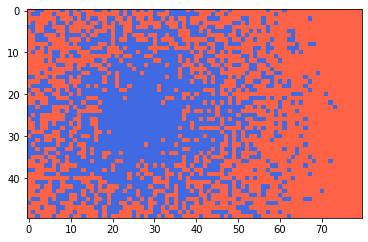

{'tomato': 0.58575, 'royalblue': 0.41425}


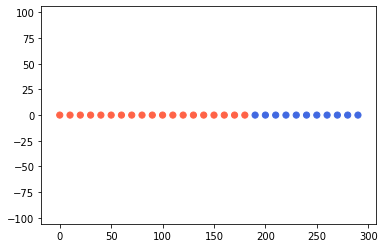

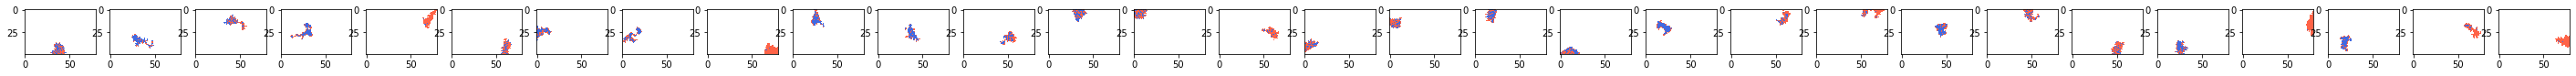

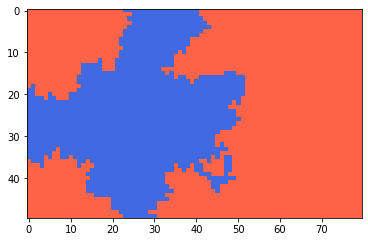

In [139]:
#Nebraska
NebraskaGrid = Grid(50, 80)
NebraskaGrid.initializeMap('Nebraska')

NebraskaGrid.displayGrid()

print(NebraskaGrid.getSummary(percentage = True))

numberOfDistrict = 30

NebraskaGrid.drawDistricts(numberOfDistrict)

NebraskaGrid.showDistrictsResult()
NebraskaGrid.showAllDistricts()
NebraskaGrid.showAllDistricts(method = 'district')


# for i in range(numberOfDistrict):
#     print("\nDistrict #", i + 1)
#     NebraskaGrid.showDistrict(i)
#     print(NebraskaGrid.getDistrictSummary(i))
#     print("Population =", NebraskaGrid.getDistrictCount(i))
#     print("MajorityColor =", NebraskaGrid.getDistrictMajorityColorId(i))

5


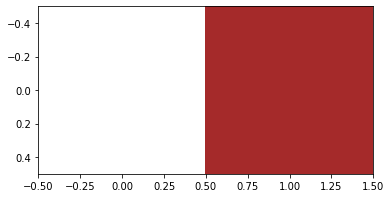

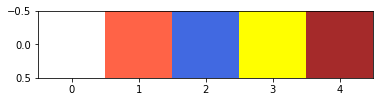

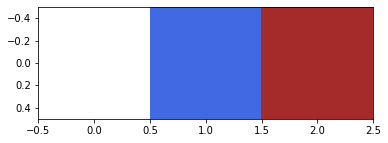

In [73]:
# testing for color map
testColorMap=matplotlib.colors.ListedColormap(['white', 'tomato', 'royalblue', 'yellow', 'brown'])
print(testColorMap.N)
testTiles = [[0, 0.5]]
plt.imshow(testTiles, cmap=testColorMap)
plt.show()

testTiles = [[0, 0.1, 0.2, 0.3, 0.4]]
plt.imshow(testTiles, cmap=testColorMap)
plt.show()

testTiles = [[0, 1, 2]]
plt.imshow(testTiles, cmap=testColorMap)
plt.show()

# plt.imshow([0, 1, 2, 3, 4, 5, 6, 7], cmap=colormap)